# Listing 7.1. Monte Carlo

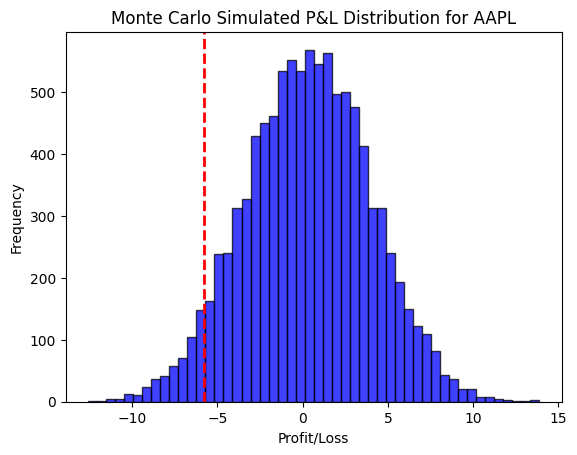

95.0% Monte Carlo VaR for AAPL: $5.76


In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Parameters
ticker = "AAPL"  # Change this to any stock ticker
confidence_level = 0.95  # 95% confidence level
num_simulations = 10000  # Number of Monte Carlo simulations
time_horizon = 1  # Days ahead for VaR calculation

# Fetch historical stock data
stock = yf.Ticker(ticker)
hist = stock.history(period="1y")  # Get 1 year of historical data

# Calculate daily returns
returns = hist['Close'].pct_change().dropna()

# Estimate mean and standard deviation of returns
mu = returns.mean()
sigma = returns.std()

# Monte Carlo simulation of stock price paths
last_price = hist['Close'].iloc[-1]
simulated_returns = np.random.normal(mu, sigma, num_simulations)
simulated_prices = last_price * (1 + simulated_returns)

# Calculate VaR at given confidence level
var_threshold = np.percentile(simulated_prices - last_price, (1 - confidence_level) * 100)

# Plot histogram of simulated returns
plt.hist(simulated_prices - last_price, bins=50, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(var_threshold, color="red", linestyle="dashed", linewidth=2)
plt.title(f"Monte Carlo Simulated P&L Distribution for {ticker}")
plt.xlabel("Profit/Loss")
plt.ylabel("Frequency")
plt.show()

# Print VaR result
print(f"{confidence_level * 100}% Monte Carlo VaR for {ticker}: ${-var_threshold:.2f}")

### Correlation

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

pd.options.display.float_format = '{:,.5f}'.format
TRADING_DAYS = 252

In [3]:
def collect_prices_returns(tickers: list):
    close_prices = pd.DataFrame()
    log_returns = pd.DataFrame()

    for ticker in tickers:
        close_prices[ticker] = yf.Ticker(ticker).history(start='2024-01-01', end='2024-12-31', interval="1d")['Close']
        log_returns[ticker] = np.log(close_prices[ticker] / close_prices[ticker].shift(1))
    return close_prices, log_returns

<Axes: >

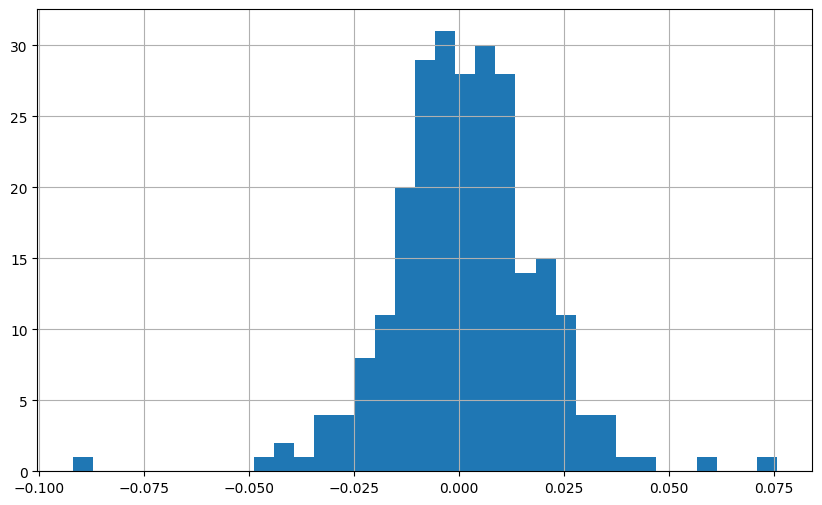

In [4]:
tickers = ["MSFT", "AMZN", "GOOGL"]
close_prices, log_returns  = collect_prices_returns(tickers)
log_returns["AMZN"].hist(bins=35, figsize=(10, 6))

In [5]:
price_stats = close_prices[tickers].agg(['mean', 'std', 'var']).T.reset_index().rename(columns={'index': 'ticker'})
price_stats

,ticker,mean,std,var
0,MSFT,417.89652,18.16172,329.84794
1,AMZN,184.49020,17.32285,300.08126
2,GOOGL,163.31029,15.40604,237.34622


In [6]:
rets = log_returns[tickers].agg(['mean', 'std', 'var']).T * [TRADING_DAYS, TRADING_DAYS**0.5, TRADING_DAYS]
rets = rets.reset_index().rename(columns={'index': 'ticker'})
rets

,ticker,mean,std,var
0,MSFT,0.14443,0.20078,0.04031
1,AMZN,0.39247,0.28154,0.07926
2,GOOGL,0.33129,0.28045,0.07865


In [7]:
cov_matrix = log_returns.cov() * TRADING_DAYS
cov_matrix

,MSFT,AMZN,GOOGL
MSFT,0.04031,0.03887,0.03239
AMZN,0.03887,0.07926,0.04290
GOOGL,0.03239,0.04290,0.07865


In [8]:
corr_matrix = log_returns.corr()
corr_matrix

,MSFT,AMZN,GOOGL
MSFT,1.00000,0.68765,0.57522
AMZN,0.68765,1.00000,0.54331
GOOGL,0.57522,0.54331,1.00000


In [9]:
close_price, log_returns = collect_prices_returns(["WMT", "NVDA"])
cov_matrix = log_returns.cov() * TRADING_DAYS
print(cov_matrix)
corr_matrix = log_returns.corr()
print(corr_matrix)

          WMT     NVDA
WMT   0.03081 -0.00049
NVDA -0.00049  0.27145
          WMT     NVDA
WMT   1.00000 -0.00532
NVDA -0.00532  1.00000


# Markowitz

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

def load_stocks(tickers, year_backs):
    start_date = datetime.today() - timedelta(days=365*year_backs)  # 3 years of data
    end_date = datetime.today()
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
    returns = stock_data.pct_change().dropna()
    return returns

In [11]:
tickers = ["AAPL", "WMT", "GOOGL", "KO", "PFE", "BRK-B", "NVDA"]
year_backs = 5
returns = load_stocks(tickers, year_backs)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


In [12]:
risk_free_rate = 0.02
TRADING_DAYS = 252
mean_returns = returns.mean() * TRADING_DAYS  # Annualized mean return
cov_matrix = returns.cov() * TRADING_DAYS  # Annualized covariance matrix

num_portfolios = 10000 # Number of portfolios to simulate
num_assets = len(tickers)

# Storage for portfolio weights, returns, risk, and Sharpe ratios
port_returns = np.zeros(num_portfolios)
port_volatility = np.zeros(num_portfolios)
sharpe_ratios = np.zeros(num_portfolios)
all_weights = np.zeros((num_portfolios, num_assets))

In [13]:
# Monte Carlo simulation for random portfolios
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    all_weights[i, :] = weights
    port_returns[i] = np.dot(weights, mean_returns)
    port_volatility[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratios[i] = (port_returns[i] - risk_free_rate) / port_volatility[i]

# Find optimal Sharpe ratio portfolio
max_sharpe_idx = np.argmax(sharpe_ratios)
optimal_weights = all_weights[max_sharpe_idx, :]

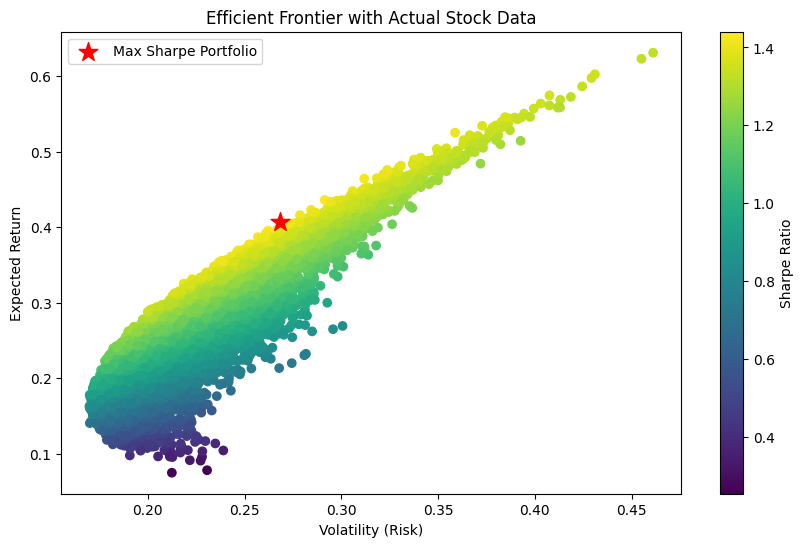

In [14]:
# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, c=sharpe_ratios, cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Actual Stock Data')

# Highlight Maximum Sharpe Ratio Portfolio
plt.scatter(port_volatility[max_sharpe_idx], port_returns[max_sharpe_idx], c='red', marker='*', s=200, label='Max Sharpe Portfolio')
plt.legend()
plt.show()


In [15]:
# Display optimal portfolio weights
optimal_portfolio_df = pd.DataFrame({
    'Stock': tickers,
    'Optimal Weight': optimal_weights
})

print(optimal_portfolio_df)

   Stock  Optimal Weight
0   AAPL         0.03001
1    WMT         0.00925
2  GOOGL         0.03924
3     KO         0.00472
4    PFE         0.35236
5  BRK-B         0.00621
6   NVDA         0.55820


# Rebalancing

In [16]:
target_allocation = {
"AAPL":        0.016804,
"WMT":        0.007427,
"GOOGL":        0.015956,
"KO":        0.142700,
"PFE":        0.193730,
"BRK-B":        0.009315,
"NVDA":        0.614068
}

In [17]:
import pandas as pd
# Define current portfolio values (in dollars)
current_portfolio = {
"AAPL":        10000,
"WMT":        10000,
"GOOGL":        10000,
"KO":        10000,
"PFE":        10000,
"BRK-B":        10000,
"NVDA":        10000,
}

# Define rebalancing threshold (e.g., 5% deviation from target)
threshold = 0.05

# Compute total portfolio value
total_value = sum(current_portfolio.values())

In [18]:
# Compute current allocations
current_allocation = {stock: value / total_value for stock, value in current_portfolio.items()}
current_allocation

{'AAPL': 0.14285714285714285,
 'WMT': 0.14285714285714285,
 'GOOGL': 0.14285714285714285,
 'KO': 0.14285714285714285,
 'PFE': 0.14285714285714285,
 'BRK-B': 0.14285714285714285,
 'NVDA': 0.14285714285714285}

In [19]:
# Compute deviations from target allocation
deviations = {stock: current_allocation[stock] - target_allocation[stock] for stock in target_allocation}

# Identify assets that need rebalancing
rebalance_needed = {stock: value for stock, value in deviations.items() if abs(value) > threshold}

# Compute necessary buys/sells to rebalance
adjustments = {}
for stock in rebalance_needed:
    target_value = target_allocation[stock] * total_value
    current_value = current_portfolio[stock]
    adjustments[stock] = target_value - current_value  # Positive = buy, Negative = sell

# Display rebalancing actions
rebalance_df = pd.DataFrame({
    "Stock": list(adjustments.keys()),
    "Current Value ($)": [current_portfolio[stock] for stock in adjustments],
    "Target Value ($)": [target_allocation[stock] * total_value for stock in adjustments],
    "Adjustment ($)": [adjustments[stock] for stock in adjustments],
    "Action": ["Buy" if adj > 0 else "Sell" for adj in adjustments.values()]
})

In [20]:
rebalance_df

,Stock,Current Value ($),Target Value ($),Adjustment ($),Action
0,AAPL,10000,"1,176.28000","-8,823.72000",Sell
1,WMT,10000,519.89000,"-9,480.11000",Sell
2,GOOGL,10000,"1,116.92000","-8,883.08000",Sell
3,PFE,10000,"13,561.10000","3,561.10000",Buy
4,BRK-B,10000,652.05000,"-9,347.95000",Sell
5,NVDA,10000,"42,984.76000","32,984.76000",Buy


# Simulating Non-FInancial Risk

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1: Define synthetic data (representing different risk factors)
data = {
    "Operational Risk": np.random.uniform(0, 100, 10),  # System downtime, security breaches
    "Regulatory Risk": np.random.uniform(0, 100, 10),  # Lawsuits, compliance fines
    "ESG Risk": np.random.uniform(0, 100, 10),         # Environmental, social, governance factors
    "Tech Obsolescence": np.random.uniform(0, 100, 10), # R&D spending, patent filings
    "Political Risk": np.random.uniform(0, 100, 10),    # Country stability, trade restrictions
    "Reputation Risk": np.random.uniform(0, 100, 10),   # Social media sentiment, brand issues
    "Management Risk": np.random.uniform(0, 100, 10)    # CEO turnover, employee satisfaction
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Step 2: Normalize data to a scale of 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Step 3: Assign weights to different risk factors (adjust based on importance)
weights = {
    "Operational Risk": 0.15,
    "Regulatory Risk": 0.15,
    "ESG Risk": 0.20,
    "Tech Obsolescence": 0.10,
    "Political Risk": 0.15,
    "Reputation Risk": 0.15,
    "Management Risk": 0.10
}

# Step 4: Compute the weighted sum for overall Non-Financial Risk Score (NFRS)
df_normalized["Non-Financial Risk Score"] = df_normalized.dot(pd.Series(weights))


In [22]:
df_normalized

,Operational Risk,Regulatory Risk,ESG Risk,Tech Obsolescence,Political Risk,Reputation Risk,Management Risk,Non-Financial Risk Score
0,70.40702,0.00000,94.34078,100.00000,90.76907,32.30638,48.98668,62.78919
1,59.16004,48.06035,100.00000,50.20688,25.57760,8.76981,100.00000,56.25586
2,8.34980,72.95226,4.48637,6.56402,27.96562,35.84018,57.67478,29.08733
3,54.34170,15.37193,75.64009,58.40069,100.00000,59.14625,12.40567,56.53764
4,100.00000,99.49885,8.52790,1.03305,34.64971,1.45447,88.48877,45.99822
5,64.83760,37.36997,12.82403,53.05638,90.03588,100.00000,85.32956,60.23992
6,13.20534,36.90914,1.52543,0.00000,77.51834,0.00000,34.03102,22.85311
7,31.77283,71.73327,45.47841,32.06561,0.00000,38.32545,0.00000,33.57698
8,0.00000,100.00000,63.66443,19.50359,30.42273,51.77963,71.00015,49.11361
9,28.51064,64.41557,0.00000,13.25496,15.43414,21.77131,85.01371,29.34662


[*********************100%***********************]  1 of 1 completed
/var/folders/6g/gq4hv4r53q35rzvjssls_3h00000gn/T/ipykernel_16677/745010029.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data = data.resample('Y').last()  # Get the last value of each year


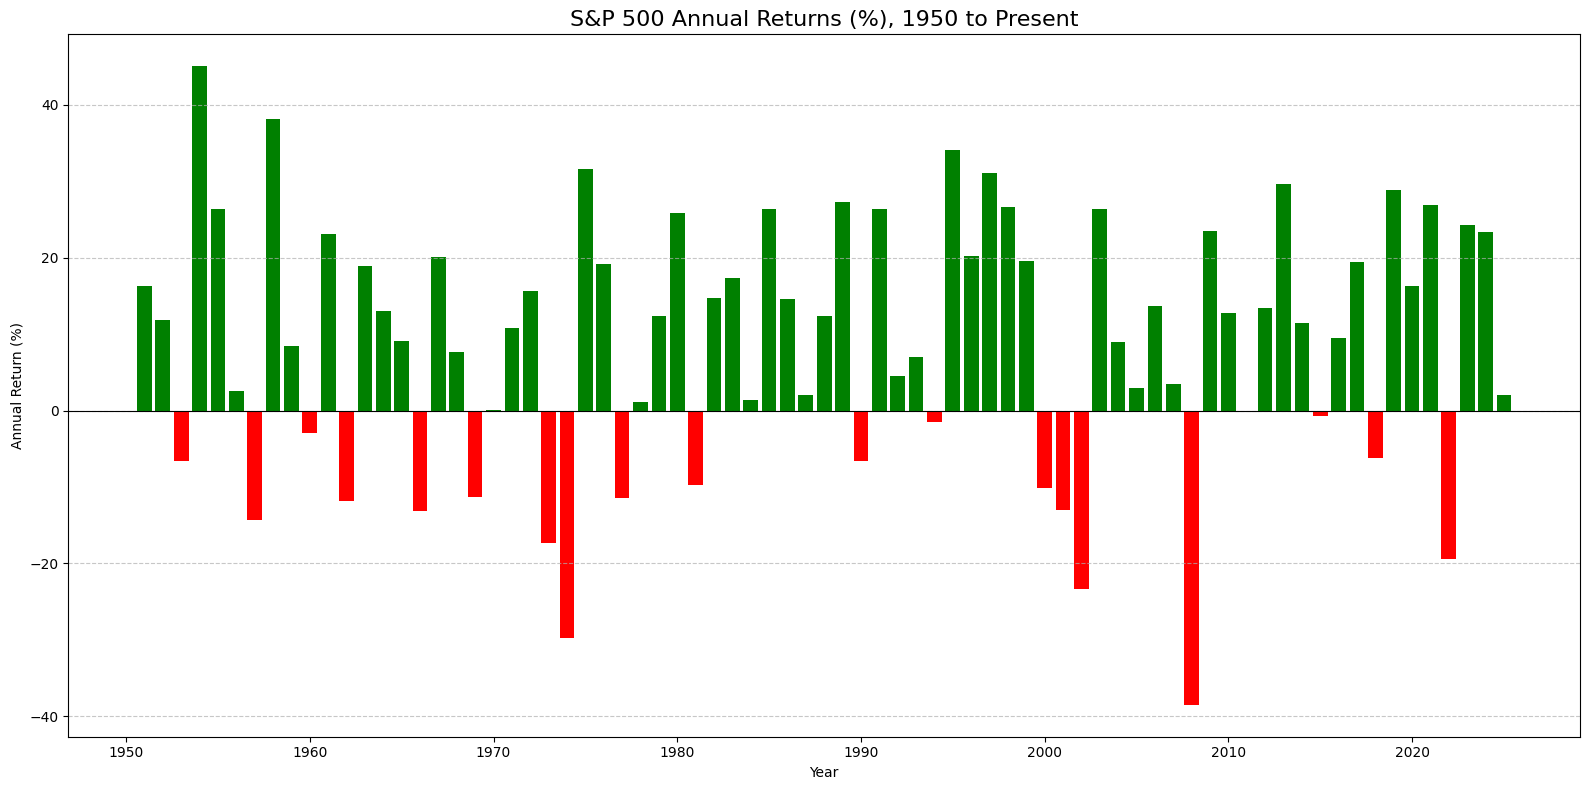

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download S&P 500 historical data (earliest possible date to today)
ticker = "^GSPC"
data = yf.download(ticker, start="1950-01-01")  # Yahoo earliest data ~1950

# Extract only the 'Adj Close' price
data = data['Close']

# Calculate annual returns
data = data.resample('Y').last()  # Get the last value of each year
returns = data.pct_change().dropna()

# Prepare DataFrame for plotting
returns_df = pd.DataFrame(returns)
returns_df.columns = ['Annual Return']
returns_df['Year'] = returns_df.index.year

# Plot positive and negative years in different colors
colors = returns_df['Annual Return'].apply(lambda x: 'green' if x > 0 else 'red')

plt.figure(figsize=(16, 8))
plt.bar(returns_df['Year'], returns_df['Annual Return'] * 100, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('S&P 500 Annual Returns (%), 1950 to Present', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
returns_df.loc[:, 'Annual Return'].mean()

np.float64(0.0921346981822878)